In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy.stats import multivariate_normal
import gpflow
from scipy.integrate import odeint, solve_bvp
from IPython import display

import surrogate as sg
from scipy.spatial.distance import cdist
import cv2

import warnings
warnings.filterwarnings("ignore")

In [2]:
N = 100

xmin = -5
xmax = 5
ymin = -5
ymax = 5

bscale = 1
l = 0.5
bw = 1.5

mscale = 0.02#0.05
vscale = 5#1e-9

x = np.linspace(xmin,xmax,N)
y = np.linspace(ymin,ymax,N)

xx,yy = np.meshgrid(x,y)

f = lambda x,y : np.cos(bw*x) - np.sin(bw*y)

occupancy_grid = np.zeros((N,N))
occupancy_grid[0,:] = 1
occupancy_grid[N-1,:] = 1
occupancy_grid[:,N-1] = 1
occupancy_grid[:,0] = 1

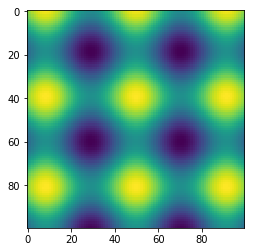

In [3]:
plt.imshow(f(xx,yy))
plt.show()

In [ ]:
def get_cost_grad(x):
   
    M,Mg,V,Vg = sm(x[0:2,:].T,gradient=True,error=True)

    return mscale*np.squeeze(Mg)-vscale*np.squeeze(Vg)

In [ ]:
def get_border_cost_grad(x):
    x = x[:,:,np.newaxis]
    mu = (np.vstack((xx.ravel(),yy.ravel())))[np.newaxis,:,occupancy_grid.ravel()==1]

    dx = -bscale/l*np.sum(np.exp(-0.5*np.sum((x-mu)**2,axis=1)/l)*(x[:,0,:]-mu[:,0,:]),axis=1)
    dy = -bscale/l*np.sum(np.exp(-0.5*np.sum((x-mu)**2,axis=1)/l)*(x[:,1,:]-mu[:,1,:]),axis=1)
    
    return np.vstack((dx,dy)).T

In [ ]:
def bvp(t,x):
    
    odx = get_cost_grad(x) + get_border_cost_grad(x[0:2,:].T)
    
    dx = (-0.5*x[3]*(1+np.cos(2*x[2])) - 0.5*x[4]*np.sin(2*x[2]))
    dy = (-0.5*x[3]*np.sin(2*x[2]) - 0.5*x[4]*(1-np.cos(2*x[2])))
    dth = -x[5]
    dl1 = -odx[:,0]
    dl2 = -odx[:,1]
    dl3 = 0.5*(x[4]**2-x[3]**2)*np.sin(x[2]) + 0.5*x[3]*x[4]*np.cos(2*x[2])
    
    dxdt = np.vstack((dx,dy,dth,dl1,dl2,dl3))
    
    return dxdt

In [ ]:
def bcr(ya,yb):
    v = -yb[3]*np.cos(yb[2]) - yb[4]*(np.sin(yb[2]))
    odx = get_cost_grad(yb.reshape(6,1)) + get_border_cost_grad(yb[0:2].reshape(1,2)).ravel()
    bc = yb[3]*v*np.sin(yb[2]) - yb[4]*v*np.cos(yb[2])
    return np.hstack((ya[0:3]-state[0:3],yb[3]-odx[0],yb[4]-odx[1],yb[5]-bc))#yb[0:2]-fin[0:2],1e-4*(yb[2]-fin[2])))

In [ ]:
def get_control(init,max_t,T):

    t = np.linspace(0,max_t,T)

    seed = np.random.randn(6,T)
    res_t = solve_bvp(bvp,bcr,t,seed,max_nodes=200,verbose=2,tol=1e-2)
    while not res_t.success:
        seed = np.random.randn(6,T)
        res_t = solve_bvp(bvp,bcr,t,seed,max_nodes=200,verbose=2,tol=1e-2)

    return res_t.sol(t)

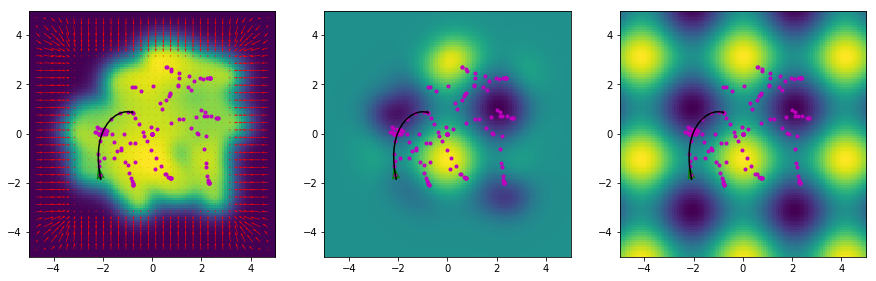

<<  WARNING  >>
		 Possible ill conditioning in covariance matrix while calculating kernel weights
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.066207e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.066207e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 9.244212e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 1.244219e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.066207e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 7.906027e+12 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition nu

<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.057243e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.063913e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.059111e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.060001e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.057907e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.055849e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to 1.000000e-10 
		 Matrix condition number = 2.058597e+13 < 1.000000e+16 maximum allowed
<<  WARNING  >>
		 Altered Tikhonov smoothing to

In [ ]:
state = np.zeros(6,)
state[0] = 0
state[1] = 0
state[2] = 0

xm = []
fm = []


plt.figure(figsize=(15,5))

states = []
states.append(state)
trajectory = state.reshape(6,1)
for j in range(30):
    
    state = trajectory.T[-1,:]
    for k in range(trajectory.shape[1]):
        xm.append(trajectory[0:2,k])
        fm.append(f(trajectory[0,k],trajectory[1,k]))
    
    sm = sg.rbf(np.array(xm),np.array(fm),function='gaussian',epsilon=1,standardise=False)
    sm.fit(iprint=1)
    M,Mg,V,Vg = sm(np.vstack((xx.ravel(),yy.ravel())).T,gradient=True,error=True)
    
    trajectory = get_control(state,10,20)
    
    states.append(trajectory.T[::2,:])
    
    bdx = get_border_cost_grad(np.vstack((xx.ravel(),yy.ravel())).T)
    
    csx = mscale*Mg[:,:,0].reshape(N,N) + vscale*(Vg[:,:,0]).reshape(N,N) + bdx[:,0].reshape(N,N)
    csy = mscale*Mg[:,:,1].reshape(N,N) + vscale*(Vg[:,:,1]).reshape(N,N) + bdx[:,1].reshape(N,N)

    plt.subplot(1,3,1)
    plt.cla()
    plt.imshow(mscale*M.reshape(N,N)-vscale*V.reshape(N,N),origin='lower',extent=[xmin,xmax,ymin,ymax])
    skip = (slice(None, None, 3), slice(None, None, 3))
    plt.quiver(xx[skip], yy[skip], -csx[skip], -csy[skip],color='r')
    plt.quiver(trajectory[0,-1], trajectory[1,-1], np.cos(trajectory[2,-1]),np.sin(trajectory[2,-1]),width=0.02,color='g')

    plt.plot(np.vstack(states)[:,0],np.vstack(states)[:,1],'m.')
    plt.plot(trajectory[0,:],trajectory[1,:],'k')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    
    plt.subplot(1,3,2)
    plt.cla()
    plt.imshow(M.reshape(N,N),origin='lower',extent=[xmin,xmax,ymin,ymax])
    plt.plot(np.vstack(states)[:,0],np.vstack(states)[:,1],'m.')
    plt.plot(trajectory[0,:],trajectory[1,:],'k')
    plt.quiver(trajectory[0,-1], trajectory[1,-1], np.cos(trajectory[2,-1]),np.sin(trajectory[2,-1]),width=0.02,color='g')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    
    plt.subplot(1,3,3)
    plt.cla()
    plt.imshow(f(xx,yy),origin='lower',extent=[xmin,xmax,ymin,ymax])
    plt.plot(np.vstack(states)[:,0],np.vstack(states)[:,1],'m.')
    plt.plot(trajectory[0,:],trajectory[1,:],'k')
    plt.quiver(trajectory[0,-1], trajectory[1,-1], np.cos(trajectory[2,-1]),np.sin(trajectory[2,-1]),width=0.02,color='g')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    
    
    display.clear_output(wait=True)
    display.display(plt.gcf())